| | |
| --- | --- |
| **Author** | Pierre Alexander Burger |
| **email** | pburger@uwatelroo.ca |

---
---
# **INTRODUCTION**
---
---

### In this notebook, we will train a neural network emulator based on JAX on the summary statistics (galaxy clustering, galaxy-galaxy lensing, and cosmic shear) of the 3x2pt of DES Y3 when varying $\omega_\mathrm{m}$, $\omega_\mathrm{b}$, $A_s$, and $w$. We use the ``cosmoemu_jax``. The structure of this notebook is identical to https://github.com/alessiospuriomancini/cosmopower/blob/main/notebooks/training_notebooks/cosmopower_NN_3times2pt.ipynb to allow a direct comparison with CosmoPower

---
---
# **PRELIMINARY OPERATIONS** 
---
---

### We will start with a few imports. We can also run it on a GPU - this is strongly recommended to speed up training. However on our Mac M3 is did not make a difference.

In [5]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os

import jax
# from jax.config import config
# config.update("jax_platform_name", "METAL") # Comment this in if you wanto to use the GPU
print(jax.devices())

[CpuDevice(id=0)]


### We will also set the random seed, for reproducibility of results. 

In [6]:
# setting the seed for reproducibility
np.random.seed(1)

---
---
# **TRAINING/TESTING DATA DOWNLOAD**
---
---

### Here, we will load the datasets for training and testing our emulator.

### For the illustrative purposes of this notebook, we will use datasets of modest size. These files can be downloaded with the provided gdrive id files.

In [7]:
import gdown
gdown.download(id='10r39tzOxNRYOIU1adO6qmqBrPdgkEb_1',output='outputs/models.npy')
gdown.download(id='1GI-y3-e_US6RIimrR9uHuUX4jeKrdQ-M',output='outputs/parameters.npz')



Downloading...
From: https://drive.google.com/uc?id=10r39tzOxNRYOIU1adO6qmqBrPdgkEb_1
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/models.npy
100%|██████████| 72.0M/72.0M [00:03<00:00, 20.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GI-y3-e_US6RIimrR9uHuUX4jeKrdQ-M
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/parameters.npz
100%|██████████| 321k/321k [00:00<00:00, 3.48MB/s]


'outputs/parameters.npz'

In [8]:
models = np.load('outputs/models.npy')
parameters = np.load('outputs/parameters.npz')
parameters.keys(),models.shape

train_sample = np.arange(0,2000)
test_sample = np.arange(2000,10000)

train_params = {}
for name in parameters.keys():
    train_params[name]=jnp.array(parameters[name])[train_sample]
    
test_params = {}
for name in parameters.keys():
    test_params[name]= jnp.array(parameters[name])[test_sample]

train_features = jnp.array(models[train_sample])
test_features = jnp.array(models[test_sample])

para_names = list(train_params.keys())

### Let’s first inspect our input features. As we can see, they vary over a large range of values and have negative values. Therefore, using the log10 of these features is not possible.

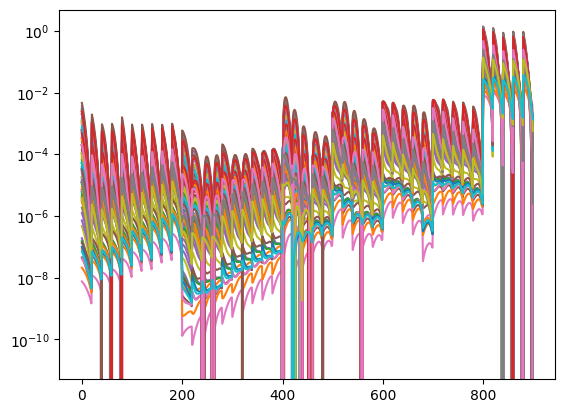

In [9]:
for i in range(100):
    plt.plot(train_features[i])
plt.yscale('log')

### Next, we load in the ``EmulatorJAX`` module and train an emulator using 2k features.

In [11]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,
    
    normalise_mode='mean_sigma',

    learning_rate=1e-3,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=False,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 0.922193, Val Loss: 0.782464
Epoch   50, Train Loss: 0.065573, Val Loss: 0.053401
Epoch  100, Train Loss: 0.082399, Val Loss: 0.059398
Epoch  150, Train Loss: 0.029489, Val Loss: 0.025734
Epoch  200, Train Loss: 0.027471, Val Loss: 0.025877
Epoch  250, Train Loss: 0.055441, Val Loss: 0.039349
Epoch  300, Train Loss: 0.025138, Val Loss: 0.022778
Epoch  350, Train Loss: 0.017942, Val Loss: 0.016285
Epoch  400, Train Loss: 0.026252, Val Loss: 0.021721
Epoch  450, Train Loss: 0.018476, Val Loss: 0.016903
Epoch  500, Train Loss: 0.017414, Val Loss: 0.015671
Epoch  550, Train Loss: 0.023059, Val Loss: 0.018840
Epoch  600, Train Loss: 0.018410, Val Loss: 0.016834
Epoch  650, Train Loss: 0.030150, Val Loss: 0.022638
Epoch  700, Train Loss: 0.022350, Val Loss: 0.019062
Epoch  750, Train Loss: 0.017580, Val Loss: 0.017425
Epoch  800, Train Loss: 0.027765, Val Loss: 0.021055
Epoch  850, Train Loss: 0.025960, Val Loss: 

### Let's inspect the loss. We multiple the vlaidation by 0.05 as we have split the training and vlaidation set in 0.95% and 0.5%.

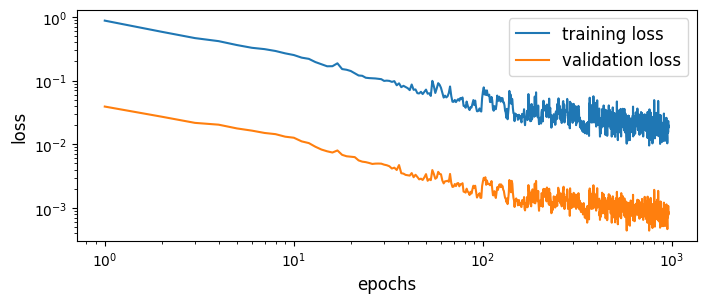

In [36]:
emulator_data = np.load('outputs/jax_env.npz')
plt.figure(figsize=(8,3))
plt.plot(np.arange(1,len(emulator_data['train_loss'])+1),emulator_data['train_loss']*0.95,label='training loss')
plt.plot(np.arange(1,len(emulator_data['val_losses'])+1),emulator_data['val_losses']*0.05,label='validation loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs',size=12)
plt.ylabel('loss',size=12)
plt.legend(fontsize=12)

### Next the accuracy. We have a decent accuracy already using only one learning rate.

Loading model from outputs/jax_env.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


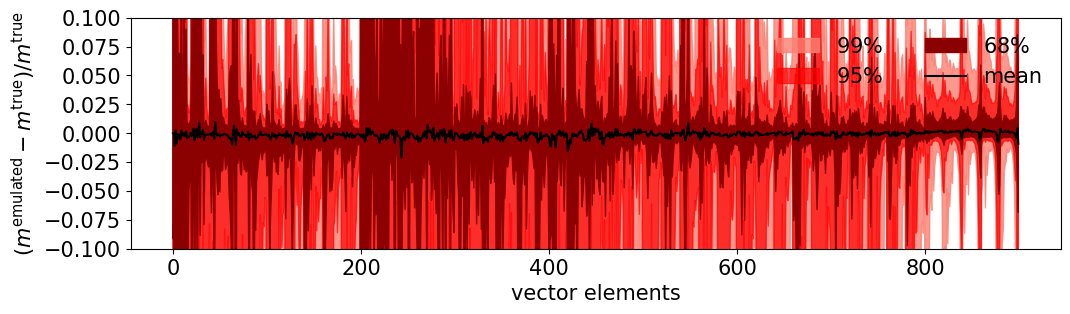

In [12]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emulated models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

### The next method is the so-called max/min scaling, which we read as $$y = \frac{y'-min(y')}{max(y')-min(y')}.$$

In [ ]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,
    
    normalise_mode='min_max',

    learning_rate=1e-3,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=False,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env_minmax',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 0.259046, Val Loss: 0.240148
Epoch   50, Train Loss: 0.030311, Val Loss: 0.025971
Epoch  100, Train Loss: 0.018798, Val Loss: 0.016701
Epoch  150, Train Loss: 0.012797, Val Loss: 0.013532
Epoch  200, Train Loss: 0.012707, Val Loss: 0.012534
Epoch  250, Train Loss: 0.018250, Val Loss: 0.015298
Epoch  300, Train Loss: 0.005675, Val Loss: 0.004810
Epoch  350, Train Loss: 0.005901, Val Loss: 0.005172
Epoch  400, Train Loss: 0.011135, Val Loss: 0.009368
Epoch  450, Train Loss: 0.006927, Val Loss: 0.006585
Epoch  500, Train Loss: 0.009984, Val Loss: 0.008357
Epoch  550, Train Loss: 0.006688, Val Loss: 0.006296
Epoch  600, Train Loss: 0.005902, Val Loss: 0.005006
Epoch  650, Train Loss: 0.003882, Val Loss: 0.003527
Epoch  700, Train Loss: 0.009125, Val Loss: 0.007816
Epoch  750, Train Loss: 0.007569, Val Loss: 0.006355
Epoch  800, Train Loss: 0.006651, Val Loss: 0.005568
Epoch  850, Train Loss: 0.006303, Val Loss: 

### Let's inspect the loss again.

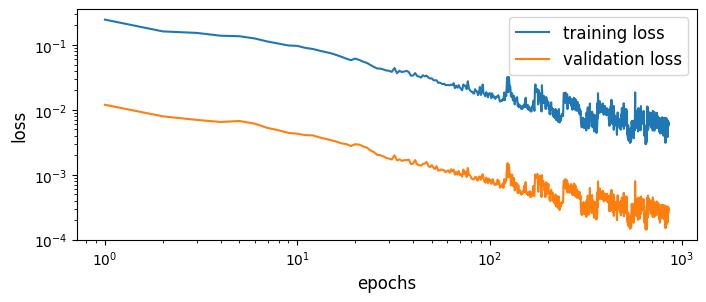

In [37]:
emulator_data = np.load('outputs/jax_env_minmax.npz')
plt.figure(figsize=(8,3))
plt.plot(np.arange(1,len(emulator_data['train_loss'])+1),emulator_data['train_loss']*0.95,label='training loss')
plt.plot(np.arange(1,len(emulator_data['val_losses'])+1),emulator_data['val_losses']*0.05,label='validation loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs',size=12)
plt.ylabel('loss',size=12)
plt.legend(fontsize=12)

### The accuracy got worse. But maybe there are applications where this normalisation helps.

Loading model from outputs/jax_env_minmax.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env_minmax.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


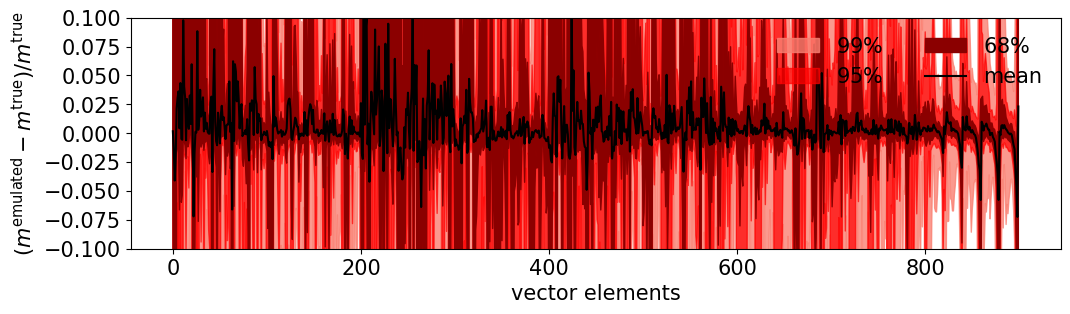

In [14]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env_minmax.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

### Finally we doing something similar to the CosmoPower and also updating the learning rate.

In [ ]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,

    normalise_mode='mean_sigma', # determines thw way the input and out features are normalised

    learning_rate=1e-1,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=True,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env_lr_updated',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 4921.863281, Val Loss: 4615.186523
Epoch   50, Train Loss: 1.982706, Val Loss: 1.876351
Epoch  100, Train Loss: 0.787392, Val Loss: 0.786758
Epoch  150, Train Loss: 0.646658, Val Loss: 0.640595
Epoch  200, Train Loss: 0.355637, Val Loss: 0.341826
Epoch  250, Train Loss: 4.482125, Val Loss: 4.640875
Epoch  300, Train Loss: 94068.117188, Val Loss: 91247.156250
Epoch  350, Train Loss: 19371.574219, Val Loss: 19413.833984
Epoch  400, Train Loss: 9864.090820, Val Loss: 9861.257812
Epoch 444: Reducing learning rate to 1.00e-02
Epoch  450, Train Loss: 18.835764, Val Loss: 18.639072
Epoch  500, Train Loss: 0.281149, Val Loss: 0.275206
Epoch  550, Train Loss: 0.150920, Val Loss: 0.145038
Epoch  600, Train Loss: 0.244236, Val Loss: 0.240366
Epoch  650, Train Loss: 1.475304, Val Loss: 1.351209
Epoch  700, Train Loss: 0.243700, Val Loss: 0.235143
Epoch  750, Train Loss: 0.159011, Val Loss: 0.153600
Epoch  800, Train Los

### The loss behaves as expected. It jumps to the next learning rate if the previous one starts to diverge.

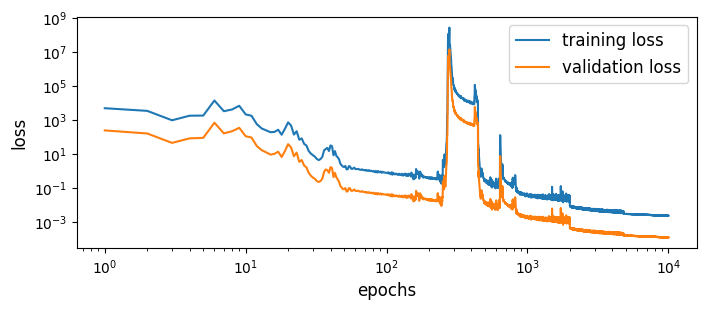

In [38]:
emulator_data = np.load('outputs/jax_env_lr_updated.npz')
plt.figure(figsize=(8,3))
plt.plot(np.arange(1,len(emulator_data['train_loss'])+1),emulator_data['train_loss']*0.95,label='training loss')
plt.plot(np.arange(1,len(emulator_data['val_losses'])+1),emulator_data['val_losses']*0.05,label='validation loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs',size=12)
plt.ylabel('loss',size=12)
plt.legend(fontsize=12)

### The accuracy now looks similar to those in CosmoPower

Loading model from outputs/jax_env_lr_updated.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env_lr_updated.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


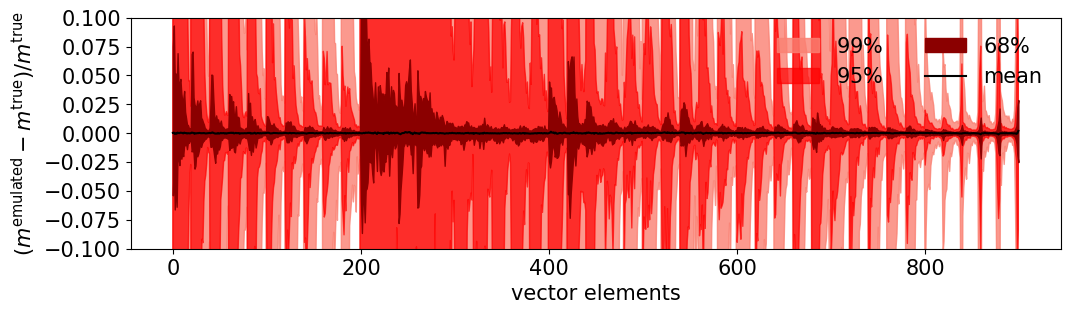

In [39]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env_lr_updated.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()